In [2]:
import rushd as rd
import pandas as pd
import numpy as np
import scipy.stats
import seaborn as sns
import matplotlib.pyplot as plt
from textwrap import wrap
from pathlib import Path
import matplotlib

import warnings
warnings.filterwarnings("ignore",category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)#, module="seaborn._oldcore")

In [ ]:
experimentdir1 = rd.datadir/'flow'/'2024.09.09_AKTi_CTV_4dpi'
experimentdir2 = rd.datadir/'flow'/'2024.09.30_AKTi_4dpi_CTV'
outputdir = rd.rootdir/'figures'/'AKTi_CTV'

In [3]:
#rd.plot.plot_well_metadata(experimentdir1/'Plate8.yaml')
#rd.plot.plot_well_metadata(experimentdir2/'Plate13.yaml')
#rd.plot.plot_well_metadata(experimentdir2/'Plate14.yaml')

# Load Data

In [4]:
data_columns = ['CTV-CellTrace™ Violet-A']

df1 = rd.flow.load_csv_with_metadata(data_path=experimentdir1/'Plate8_csv',yaml_path=experimentdir1/'Plate8.yaml',columns=data_columns)
df2 = rd.flow.load_csv_with_metadata(data_path=experimentdir2/'Plate13_csv',yaml_path=experimentdir2/'Plate13.yaml',columns=data_columns)
df3 = rd.flow.load_csv_with_metadata(data_path=experimentdir2/'Plate14_csv',yaml_path=experimentdir2/'Plate14.yaml',columns=data_columns)

df = pd.concat([df1, df2, df3])

In [5]:
df=df.rename(columns={'CTV-CellTrace™ Violet-A':'CTV-A'})

In [6]:
df['condition'] = df['infection'] + ' ' + df['inhibitor'] + ' ' + df['concentration'] + " " + df['rep']

Get rid of negative values

In [7]:
#num = df._get_numeric_data()
x = ['CTV-A']

for i in np.arange(0,np.size(x)):
    df = df.loc[df[x[i]]>0]


# CTV gate

In [8]:
# Get CTV gate for each replicate

CTV_gates = {}

for i in df.rep.unique():
    CTV_gates[i] = df[(df['infection'] == 'Puro') & (df['rep'] == i)]['CTV-A'].quantile(0.2)

In [9]:
groups = ['rep','cassette', 'inhibitor', 'concentration','condition','well'] # 'rep' must be first group!!!!

def percent_hyperP(x):
    rep = x.name[0]  # Assuming 'rep' is the first group
    gate_value = CTV_gates[rep]
    return np.mean(x < gate_value) * 100

def total_hyperP(x):
    rep = x.name[0] # Assuming 'rep' is the first group
    gate_value = CTV_gates[rep]
    return np.sum(x < gate_value)


# Create the summary statistics dataframe
summary_df = pd.concat([
    df.groupby(groups)['CTV-A'].apply(percent_hyperP).rename('(%) HyperP'),
    df.groupby(groups)['CTV-A'].apply(total_hyperP).rename('(#) Total HyperP'),
    df.groupby(groups)['CTV-A'].apply(lambda x: np.size(x)).rename('Total Cell Count'),
], axis=1)
summary_df = summary_df.reset_index()

data2plot = ['(%) HyperP','(#) Total HyperP','Total Cell Count']


# Plotting Functions

In [10]:
def custom_barplot(x,y,data,filename,height=4,width=8,hue=None,xlabel_rot=90,xlabel='',plottitle='',palette='viridis',order=None,hue_order=None,pairs=None,alpha=0.8,reps=None):
    aspect = width / height
    g = sns.catplot(x=x,y=y,data=data,height=height,aspect=aspect,palette=palette,kind='bar',hue=hue,order=order,hue_order=hue_order,alpha=alpha,errorbar='ci',legend=None)
    ax = plt.gca()
    
    if order != None:
        #labels = [ '\n'.join(wrap(l, 4)) for l in order]
        labels = [ '\n'.join(l.split(' ')) for l in order]
    else:
        labels = None

    if hue == None:
        dodge = False
    elif hue != None:
        dodge = True

    if reps is None:
        g.map_dataframe(sns.stripplot, x=x,y=y, 
                    hue=hue, palette=["#404040"], 
                    alpha=0.8, dodge=dodge,order=order,hue_order=hue_order)
    
    marker_list = ['o', '^', 's', 'D', 'P', 'X']

    if reps is not None:
        for (j, rep) in enumerate(data[reps].unique()):
            sns.stripplot(
                ax=ax, data=data[data[reps] == rep],
                x=x, y=y,
                order=order,
                hue=hue,
                hue_order=hue_order,
                dodge=dodge, marker=marker_list[j],
                palette=['white'], size=5,
                edgecolor='black', linewidth=0.4,
                legend=None)

    if pairs != None:
        annotator = Annotator(ax,pairs,data=data,x=x,y=y,order=order)
        annotator.configure(test='t-test_ind',text_format='star',loc='inside', verbose=2)
        annotator.apply_and_annotate()
        #add_stat_annotation(ax, data=data, x=xcat, y=ycat, order=order,
        #            box_pairs=pairs,
        #            test='t-test_ind', text_format='star', verbose=2)

    ymin, ymax = ax.get_ylim()
    if ymax > 1000:
        k_formatter = matplotlib.ticker.FuncFormatter(lambda x, _: f'{x:.0f}' if abs(x) < 1000 else f'{x/1000:.0f}k')
        ax.yaxis.set_major_formatter(k_formatter)

    sns.despine(fig=None, ax=None, top=False, right=False, left=False, bottom=False, offset=None, trim=False) # make plot bounded on all sides
    
    g.set_xticklabels(labels,rotation=xlabel_rot, horizontalalignment='center' if xlabel_rot==0 else 'right')
    plt.xlabel(xlabel)
    plt.ylabel(y)
    plt.title(plottitle)

    if hue is not None:
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.0, frameon=False)  # Adjust bbox_to_anchor as needed

    plt.subplots_adjust(left=0.2, right=0.95, top=0.9, bottom=0.25) # make all plots have the same area
    #g.tight_layout()
    g.savefig(outputdir/str(filename + '.svg'),dpi=300)


def custom_catplot(xcat,ycat,dataslice,savetitle,height=4,width=8,xlabel_rot=0,xlabel='',plottitle='',order=None,palette=None,pairs=None):
    if palette != None:
        hue = xcat
        color = None
    elif palette == None:
        hue = None
        color = '#000000'
    aspect = width / height
    g = sns.catplot(x=xcat,y=ycat,data=dataslice,height=height,aspect=aspect,zorder=1,palette=palette,order=order,hue=hue,color=color,s=70)
    g.map_dataframe(sns.pointplot, x=xcat,y=ycat,errorbar='se',join=False,capsize=0.22,ax=g.ax,palette=palette,markers='_',scale=1.5,errwidth=1.5,order=order,hue=hue,color=color)
    #sns.pointplot(x=xcat,y=ycat,data=dataslice,errorbar='se',join=False,capsize=0.22,ax=g.ax,palette=palette,markers='_',scale=1.5,errwidth=1.5,order=order,hue=hue,color=color)
    ax = plt.gca()
    
    #plt.ticklabel_format(axis='y',style='sci',scilimits=(0,0))  # this is for if you want scientific y axis labels (e.g. 10^4 instead of 10000)
    if order != None:
        #labels = [ '\n'.join(wrap(l, 16)) for l in order]
        labels = [ '\n'.join(l.split(' ')) for l in order]
    else:
        labels = None

    if pairs != None:
        annotator = Annotator(g.ax,pairs,data=dataslice,x=xcat,y=ycat,order=order)
        annotator.configure(test='Kruskal',text_format='star',loc='inside')
        annotator.apply_and_annotate()

    ymin, ymax = ax.get_ylim()
    if ymax > 1000:
        plt.ticklabel_format(axis='y',style='sci',scilimits=(0,0))

    #sns.despine(fig=None, ax=None, top=False, right=False, left=False, bottom=False, offset=None, trim=False)
    plt.subplots_adjust(left=0.2, right=0.95, top=0.9, bottom=0.25) # make all plots have the same area
    g.set_xticklabels(labels,rotation=xlabel_rot, horizontalalignment='center' if xlabel_rot==0 else 'right')
    g.tight_layout()
    plt.legend([],[], frameon=False)
    plt.xlabel(xlabel)
    plt.ylabel(ycat)
    plt.title(plottitle)
    
    g.savefig(outputdir/str(savetitle + '.png'),dpi=300)
    g.savefig(outputdir/str(savetitle + '.svg'),dpi=300)

def custom_hist(xcat,data,order,hue,savetitle=None,palette='muted',gate=None,xlim=[10,5*10**4]):
    plt.figure(figsize=(8,4))
    if xcat in ['FSC-A','FSC-H']:
        log = False
        plt.ticklabel_format(axis='x', style='scientific', scilimits=(0, 0))
    else:
        log = True
    g = sns.kdeplot(data=data,x=xcat,hue=hue,log_scale=log,common_norm=False,hue_order=order,palette=palette, linewidth=2.5,fill=True,alpha=0.08)

    if gate is not None:
        plt.axvline(x=gate,linestyle='--',color='black',linewidth=2.5)

    sns.move_legend(g, loc='upper left', bbox_to_anchor=(1,1), frameon=False)
    plt.xlim(xlim)
    plt.title('4 dpi')
    plt.xlabel(xcat)
    plt.tight_layout()
    g.savefig(outputdir/str(savetitle + '.png'),dpi=300)
    g.savefig(outputdir/str(savetitle + '.svg'),dpi=300)

def scatter(xcat,ycat,data,order,hue,savetitle,figsize=(7,4),palette='muted',sci=None,log='none',xlim=None,ylim=None):
    xcatSEM = xcat + ' SEM'
    ycatSEM = ycat + ' SEM'

    # Make the figure
    fig, ax = plt.subplots(figsize=figsize)
    plt.errorbar(x=xcat, y=ycat, xerr=xcatSEM, 
                yerr=ycatSEM,data=data, capsize=2, elinewidth=0.7,capthick=0.7,ls='none',color='grey')

    # Make the dots
    sns.scatterplot(data=data, x=xcat, y=ycat, hue=hue,hue_order=order,palette=palette,zorder=3,s=100)

    # Remove error bars from the legend
    handles, labels = ax.get_legend_handles_labels()
    handles[-1] = []
    labels[-1]= []
    ax.legend(handles=handles,labels=labels,bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

    # Change axis limit
    if xlim is not None:
        plt.xlim(xlim)
    if ylim is not None:
        plt.ylim(ylim)

    # Change x and y axes to log or scientific notation as desired
    if sci != None:
        plt.ticklabel_format(axis=sci,style='sci',scilimits=(0,0))
    if 'x' in log:
        ax.set_xscale('log')
    if 'y' in log:
        ax.set_yscale('log')
    plt.tight_layout()    
    g.savefig(outputdir/str(savetitle + '.png'),dpi=300)
    g.savefig(outputdir/str(savetitle + '.svg'),dpi=300)

# Plot Results

MK-2206, RISDD and SDDIR

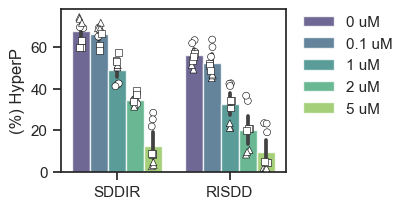

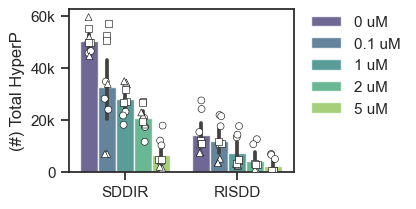

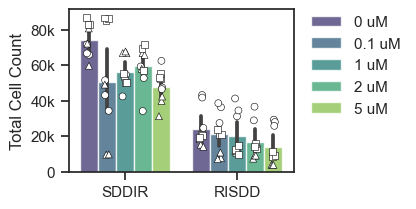

In [11]:
sns.set_theme(style="ticks",font_scale=1)

order = ['SDDIR','RISDD']


slice2 = summary_df[(summary_df['inhibitor'].isin(['MK-2206', 'DMSO'])) & (summary_df['cassette'].isin(['SDDIR','RISDD']))]

for i in data2plot:
    savetitle = 'MK-2206_' + i
    custom_barplot('cassette', i, slice2, savetitle,
                    order = order,
                    hue = 'concentration',
                    hue_order=['0 uM', '0.1 uM','1 uM','2 uM', '5 uM'],
                    palette='viridis',
                    height=2.5,
                    width=3,
                    xlabel_rot=0,
                    alpha=0.8,
                    reps='rep',
                    )
    


ARQ-092

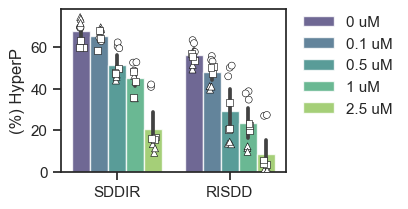

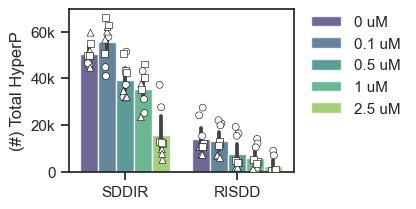

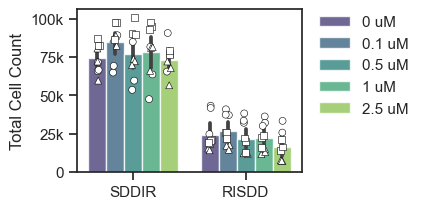

In [12]:
order = ['SDDIR','RISDD']
slice1 = summary_df[(summary_df['inhibitor'].isin(['ARQ-092', 'DMSO'])) & (summary_df['cassette'].isin(['SDDIR','RISDD']))]


for i in data2plot:
    savetitle = 'ARQ-092_' + i
    custom_barplot('cassette',i,slice1,savetitle,
                    order = order,
                    hue = 'concentration',
                    hue_order=['0 uM','0.1 uM','0.5 uM', '1 uM', '2.5 uM'],
                    palette='viridis',
                    height=2.5,
                    width=3,
                    xlabel_rot=0,
                    alpha=0.8,
                    reps='rep',
                    )
    

    
